In [164]:
import ROOT
import copy

In [165]:
input_file = "outroot/nSidis_005032.root"
tfile = ROOT.TFile(input_file)
tree = tfile.Get("diphoton")

In [166]:
def get_fit_counts_purity(hist):
    fit = ROOT.TF1("fit","gaus(0)+pol2(3)",0.08,0.23)
    HIST = copy.deepcopy(hist)
    scale=HIST.GetEntries()
    HIST.Scale(1/HIST.GetEntries())
    fit.SetParameters(0.5,0.135,0.002,1,1,1)
    fit.SetParLimits(0,0.01,1)
    fit.SetParLimits(1,0.129,0.14)
    fit.SetParLimits(2,0.005,0.02)
    HIST.Fit(fit,"NR0")
    
    # Get the parameters of the Gaussian component
    mean = fit.GetParameter(1)
    sigma = fit.GetParameter(2)
    amplitude = fit.GetParameter(0)
    
    # Create a TF1 object for the Gaussian component
    xmin,xmax=0.106,0.164
    gaus_func = ROOT.TF1("gaus_func", "gaus", xmin,xmax)
    gaus_func.SetParameters(amplitude, mean, sigma)

    # Get the parameters of the polynomial component
    pol2_params = [fit.GetParameter(i) for i in range(3, 6)]

    # Create a TF1 object for the polynomial component
    pol2_func = ROOT.TF1("pol2_func", "pol2", xmin,xmax)
    [pol2_func.SetParameter(i,pol2_params[i]) for i in range(len(pol2_params))]
    
    gaus_int = gaus_func.Integral(mean-2*sigma,mean+2*sigma)
    pol_int = pol2_func.Integral(mean-2*sigma,mean+2*sigma)

    purity = (gaus_int)/(gaus_int+pol_int)
    
    # Get the bin numbers corresponding to purity edges
    bin_low = hist.FindBin(mean-2*sigma)
    bin_high = hist.FindBin(mean+2*sigma)
    # Calculate the integral of the histogram between these bins
    integral = hist.Integral(bin_low, bin_high)
    # Rescale fit params
    
    for ipar in [0,3,4,5]:
        fit.SetParameter(ipar,fit.GetParameter(ipar)*scale)
    fit.SetNpx(1000000)
    if(purity<0.01): # Return -1 because the fit may have failed
        return -1,-1,-1
    else:
        return copy.deepcopy(fit),purity*integral,purity

Purity (mean +/- 2*sigma)
  No cuts --> 0.47489311867705325
  Egamma>0.6 --> 0.78163616914757
  Classifier p>0.9 cuts --> 0.7337605976402233
 FCN=63.0594 FROM MIGRAD    STATUS=CONVERGED     845 CALLS         846 TOTAL
                     EDM=1.58171e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.0 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.09780e-02   1.23136e-04   5.42584e-07   7.71538e-03
   2  p1           1.33959e-01   1.61285e-04   1.63674e-05   9.37324e-04
   3  p2           1.45668e-02   2.03788e-04  -3.28681e-05   1.94761e-03
   4  p3           1.51261e-03   4.14719e-04   6.13940e-09  -5.61945e-01
   5  p4           8.18864e-02   6.19988e-03   6.15208e-07  -1.20531e-01
   6  p5          -2.86444e-01   2.05261e-02  -3.05862e-06  -2.55663e-02
 FCN=50.0556 FROM MIGRAD    STATUS=CONVERGED     444 CALLS         445 TOTAL
                     EDM=1.763

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 


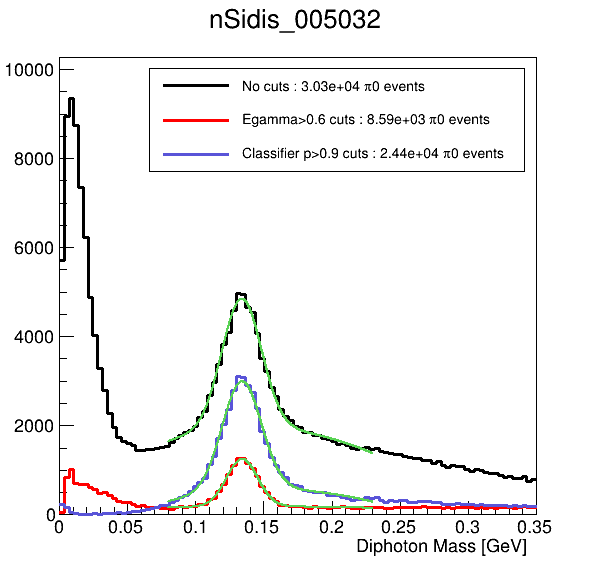

In [167]:
canvas = ROOT.TCanvas("c","c",600,600)
p_thresh = 0.9

title = input_file.split("/")[-1].replace(".root","")
hist_min,hist_max=0,0.35
h1 = ROOT.TH1F("h1",title+";Diphoton Mass [GeV];Counts",100,hist_min,hist_max)
h2 = ROOT.TH1F("h2",title+";Diphoton Mass [GeV];Counts",100,hist_min,hist_max)
h3 = ROOT.TH1F("h3",title+";Diphoton Mass [GeV];Counts",100,hist_min,hist_max)

h1.SetLineColor(1); h2.SetLineColor(2); h3.SetLineColor(9);
h1.SetLineWidth(3); h2.SetLineWidth(3); h3.SetLineWidth(3);

tree.Draw("M_gg>>h1","","hist")
tree.Draw("M_gg>>h2","E_gamma_1>0.6 && E_gamma_2>0.6","hist same")
tree.Draw("M_gg>>h3","p_gamma_1>{}&&p_gamma_2>{}".format(p_thresh,p_thresh),"hist same")

h1.GetYaxis().SetRangeUser(0,h1.GetMaximum()*1.1)
ROOT.gStyle.SetOptStat(0)
legend=ROOT.TLegend(0.25,0.7,0.88,0.88)
f1,N1,u1=get_fit_counts_purity(h1); f1.SetLineColor(8); f1.SetLineStyle(9);
f2,N2,u2=get_fit_counts_purity(h2); f2.SetLineColor(8); f2.SetLineStyle(9);
f3,N3,u3=get_fit_counts_purity(h3); f3.SetLineColor(8); f3.SetLineStyle(9);

f1.Draw("l same")
f2.Draw("l same")
f3.Draw("l same")

legend.AddEntry(h1,"No cuts : {:.2e} #pi0 events".format(int(N1)),"l")
legend.AddEntry(h2,"Egamma>0.6 cuts : {:.2e} #pi0 events".format(int(N2)),"l")
legend.AddEntry(h3,"Classifier p>{} cuts : {:.2e} #pi0 events".format(p_thresh,int(N3)),"l")
legend.Draw()
canvas.Draw()

print("Purity (mean +/- 2*sigma)")
print("  No cuts -->",u1)
print("  Egamma>0.6 -->",u2)
print("  Classifier p>{} cuts -->".format(p_thresh),u3)